### US_NR1_hillslope
First look at affects of elevation and aspect in a simple hillslope run for Boulder County forced with tower data from US-NR1.
- Created by Will Wieder wwieder@ucar.edu
- Created on 2 March, 2023

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import utils
import cftime
import nc_time_axis
import dask
#import cf_units as cf

# some resources for plotting
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.lines as mlines
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
from matplotlib.pyplot import cm
import matplotlib.animation as animation

from IPython.display import HTML, display

# supress Runtime warnings that let you know when code isn't too efficiently
import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)
from distributed import wait

%matplotlib inline

In [2]:
# This is needed to display graphics calculated outside of jupyter notebook


In [3]:
# Updated for PBS scheduler
# this could go into utils.
# By default gets 1 core w/ 25 GB memory
def get_ClusterClient(ncores=1, nmem='25GB'):
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    ncores=ncores
    nmem = nmem

    cluster = PBSCluster(
        cores=ncores, # The number of cores you want
        memory=nmem, # Amount of memory
        processes=ncores, # How many processes
        queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
        resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
        project='P93300641', # Input your project ID here
        walltime='3:00:00', # Amount of wall time
        interface='ib0', # Interface to use
    )

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })

    client = Client(cluster)
    return cluster, client

In [4]:
#cluster, client = get_ClusterClient(nmem='5GB')
#cluster.scale(5)

In [5]:
#cluster

In [6]:
# Niwot LTER  simulations
# H1 files dimensioned time x column or time x pft

## for moist meadow experiments
case  =  ['US-NR1_hh_test1_sp']
years = range(15,17)

rollHour = -12  

dirIn = ['/glade/scratch/wwieder/archive/'+case[c]+'/lnd/hist/' for c in range(len(case))]
#dirIn = ['/glade/scratch/wwieder/'+case[c]+'/run/' for c in range(len(case))]

dsIn = [dirIn[0] + case[0] +'.clm2.h1.00'+str(years[i]) +'-01-01-00000.nc' \
           for i in range(len(years)) ]  
dsIn

['/glade/scratch/wwieder/archive/US-NR1_hh_test1_sp/lnd/hist/US-NR1_hh_test1_sp.clm2.h1.0015-01-01-00000.nc',
 '/glade/scratch/wwieder/archive/US-NR1_hh_test1_sp/lnd/hist/US-NR1_hh_test1_sp.clm2.h1.0016-01-01-00000.nc']

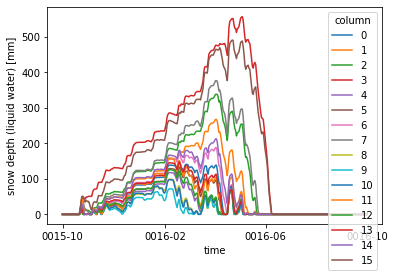

In [7]:
ds = xr.open_mfdataset(dsIn, decode_times=True, combine='by_coords').persist()
# Shift to water year
shift = -273  #starts water year Oct 1
ds = ds.shift(time=shift)
ds['time'] = ds.time.shift(time=shift)

ds.H2OSNO.isel(time=slice(0,365)).plot(hue='column') ;

**Aspect:**  (_ds.hslp_aspect.isel(time=0).values_)
- N = 0-3 
- E = 4-7  
- S = 8-11  
- W = 12-15 

**Elevation:**  (_ds.hslp_elev.isel(time=0).values_)
- Low 0, 4, 8, 12
- High 3, 7, 11, 15 

In [8]:
ds.hslp_elev.isel(time=0).values

array([4.98204853e-01, 2.80999193e+01, 9.69598783e+01, 2.60464459e+02,
       3.04513973e-01, 2.77913072e+01, 9.64188132e+01, 2.40037773e+02,
       2.08321475e-01, 2.75704132e+01, 9.66664849e+01, 2.68795007e+02,
       3.25363262e-01, 2.86769612e+01, 9.85421106e+01, 3.35079741e+02])

In [9]:
ds['aspect'] = ['N','N','N','N',
                'E','E','E','E',
                'S','S','S','S',
                'W','W','W','W']

ds['elevation'] = [1,2,3,4, 1,2,3,4,
                   1,2,3,4, 1,2,3,4]
#                   'lower montain','upper montaine','sub alpine','alpine',
#                   'lower montain','upper montaine','sub alpine','alpine',
#                   'lower montain','upper montaine','sub alpine','alpine']


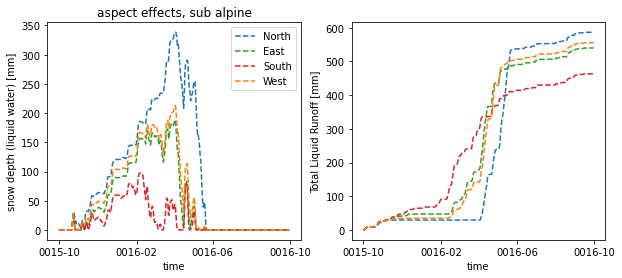

In [10]:
var = ['H2OSNO','QRUNOFF']
col = [2,6,10,14]
label=['North','East','South','West']
colors=['tab:blue','tab:green','tab:red','tab:orange']
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True,figsize=[10,4])

for v in range(len(var)):
    plt.subplot(1,2,(v+1))
    for c in range(len(col)):
        plotVar = ds[var[v]].isel(time=slice(0,365), column=col[c])
        if v == 0: 
            plotVar.plot(label=label[c], linestyle='--',color=colors[c])
            plt.title('aspect effects, sub alpine')
            plt.legend() 
        else:
            (plotVar*3600*24).cumsum().plot(label=label[c], linestyle='--',color=colors[c])
            plt.ylabel('Total Liquid Runoff [mm]');


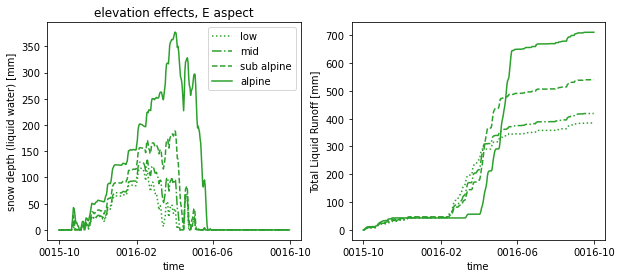

In [11]:
col = [4,5,6,7]
label=['low','mid','sub alpine','alpine']
lt = [':','-.','--','-']
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True,figsize=[10,4])

for v in range(len(var)):
    plt.subplot(1,2,(v+1))
    for c in range(len(col)):
        plotVar = ds[var[v]].isel(time=slice(0,365), column=col[c])
        if v == 0: 
            plotVar.plot(label=label[c], color=colors[1],linestyle=lt[c] )
            plt.title('elevation effects, E aspect')
            plt.legend() 
        else:
            (plotVar*3600*24).cumsum().plot(label=label[c],color=colors[1],linestyle=lt[c])
            plt.ylabel('Total Liquid Runoff [mm]');
        
        

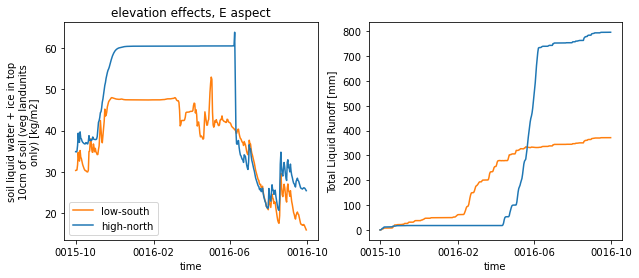

In [12]:
var = ['SOILWATER_10CM','QRUNOFF']

col = [8, 3]
label=['low-south', 'high-north']
colors=['tab:orange','tab:blue']
lt = ['-','-']
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True,figsize=[10,4])

for v in range(len(var)):
    plt.subplot(1,2,(v+1))
    for c in range(len(col)):
        plotVar = ds[var[v]].isel(time=slice(0,365), column=col[c])
        if v == 0: 
            plotVar.plot(label=label[c], color=colors[c],linestyle=lt[c] )
            plt.title('elevation effects, E aspect')
            plt.legend() 
        else:
            (plotVar*3600*24).cumsum().plot(label=label[c],color=colors[c],linestyle=lt[c])
            plt.ylabel('Total Liquid Runoff [mm]');
        
        

## remap colums to DEM


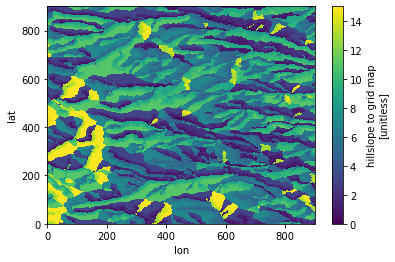

In [13]:
ds_grid = '/glade/scratch/wwieder/map_hillslope_to_grid_NR.nc'
ds_grid = xr.open_dataset(ds_grid)
ds_grid.hillslope_to_grid.plot() ;

In [15]:
ds_grid['H2OSNO'] = ds_grid.hillslope_to_grid
ds_grid['hh_grid'] = ds_grid.hillslope_to_grid.astype("int")

for i in range(len(ds.column)):
    ds_grid['H2OSNO'] = xr.where(ds_grid['hh_grid'] == i, ds.H2OSNO.isel(column=i), ds_grid['H2OSNO'])
    
ds_grid.load()

<xarray.Dataset>
Dimensions:            (lat: 901, lon: 901, naspect: 4, nhand: 5, time: 730)
Coordinates:
  * time               (time) object 0015-10-01 00:00:00 ... nan
Dimensions without coordinates: lat, lon, naspect, nhand
Data variables:
    longitude          (lon) float64 254.3 254.3 254.3 ... 254.6 254.6 254.6
    latitude           (lat) float64 40.19 40.19 40.19 ... 39.94 39.94 39.94
    aspect_bins        (naspect) float64 0.0 90.0 180.0 270.0
    hand_bins          (nhand) float64 0.0 2.0 59.0 144.0 1e+06
    hillslope_to_grid  (lat, lon) float64 1.0 1.0 1.0 12.0 ... 8.0 8.0 8.0 8.0
    H2OSNO             (lat, lon, time) float64 0.0 0.0 0.0 0.0 ... nan nan nan
    hh_grid            (lat, lon) int64 1 1 1 12 13 13 13 13 ... 4 4 4 8 8 8 8 8
Attributes:
    note:     outer loop over aspect, inner loop over hand bins

In [14]:
ds.H2OSNO

<xarray.DataArray 'H2OSNO' (time: 730, column: 16)>
dask.array<rechunk-merge, shape=(730, 16), dtype=float32, chunksize=(365, 16), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0015-10-01 00:00:00 0015-10-02 00:00:00 ... nan nan
Dimensions without coordinates: column
Attributes:
    long_name:     snow depth (liquid water)
    units:         mm
    cell_methods:  time: mean

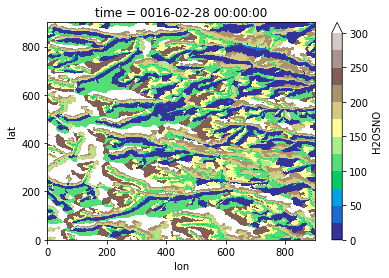

In [16]:
ds_grid['H2OSNO'].isel(time=150).plot(
    cmap='terrain',vmax=300,vmin=0,levels=13);

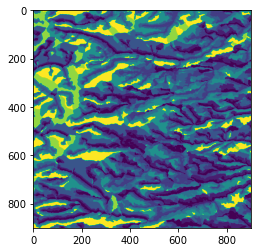

In [17]:
import matplotlib.animation as animation
# ims is a list of lists, each row is a list of artists to draw in the
# current frame; here we are just animating one artist, the image, in
# each frame
fig, ax = plt.subplots()

ims = []
for i in range(6):
    im = ax.imshow(ds_grid['H2OSNO'].isel(time=(100+i)), animated=True)
    if i == 0:
        ax.imshow(ds_grid['H2OSNO'].isel(time=(100+i)))  # show an initial one first
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)

# To save the animation, use e.g.
#
# ani.save("movie.mp4")
#
# or
#
# writer = animation.FFMpegWriter(
#     fps=15, metadata=dict(artist='Me'), bitrate=1800)
# ani.save("movie.mp4", writer=writer)

plt.show()

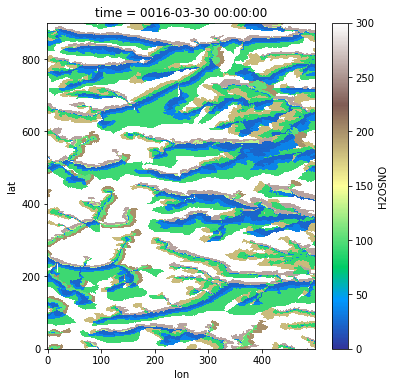

In [21]:
#Trying this examples from https://climate-cms.org/posts/2019-09-03-python-animation.html

# Get a handle on the figure and the axes
tas = ds_grid['H2OSNO'].isel(lon=slice(0,500))
fig, ax = plt.subplots(figsize=(6,6))

# Plot the initial frame. 
cax = tas[:,:,180].plot(
    add_colorbar=True,
    cmap='terrain',
    vmax=300,vmin=0,
    cbar_kwargs={
        'extend':'neither'
    }
)

# Next we need to create a function that updates the values for the colormesh, as well as the title.
def animate(frame):
    cax.set_array(tas[:,:,(180+frame)].values.flatten())
    ax.set_title("Time = " + str(tas.coords['time'].values[(180+frame)])[:13])

# Finally, we use the animation module to create the animation.
ani = animation.FuncAnimation(
    fig,             # figure
    animate,         # name of the function above
    frames=100,       # Could also be iterable or list
    interval=200     # ms between frames
)

In [19]:
display(HTML(ani.to_jshtml())) 


In [20]:
for i in range(40):
    ds_grid['H2OSNO'].isel(time=(100+i)).plot(
        figsize = (12,6)      # We'll make it a bit bigger
    )
    plt.title("Time = " + str(ds_grid.coords['time'].values[(100+i)])[:13])
    plt.savefig(f"/glade/scratch/wwieder/animations/Python_Animation_01_frame_{i:04}.png")
    plt.close()

In [35]:
!convert /glade/scratch/wwieder/animations/Python_Animation_01_frame_*.png /glade/scratch/wwieder/animations/Python_Animation_01_frame_*.gif
display(HTML("<img src='/glade/scratch/wwieder/animations/Python_Animation_01_frame_*.gif' />"))

NameError: name 'HTML' is not defined

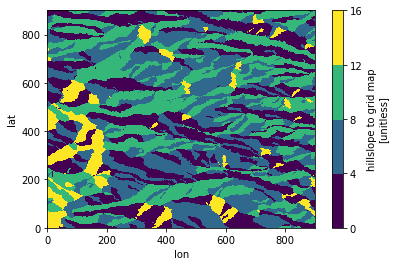

In [17]:
ds_grid.hillslope_to_grid.plot(levels=5) ;

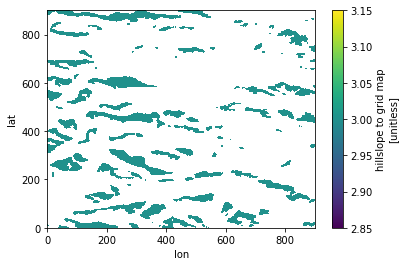

In [18]:
ds_grid.hillslope_to_grid.where(ds_grid.hillslope_to_grid==3).plot()

#### Quick look at LAI modifications for US-NR1

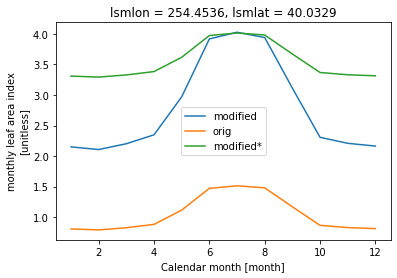

In [9]:
surDat = '/glade/scratch/wwieder/US-NR1_single_point_data/surfdata_0.9x1.25_hist_16pfts_Irrig_CMIP6_simyr2000_US-NR1_c220922.nc'
surDat2 = '/glade/scratch/wwieder/US-NR1_single_point_data/surfdata_0.9x1.25_hist_16pfts_Irrig_CMIP6_simyr2000_US-NR1_LAIx2.66.nc'
surDat3 = '/glade/scratch/wwieder/US-NR1_single_point_data/surfdata_0.9x1.25_hist_16pfts_Irrig_CMIP6_simyr2000_US-NR1_LAI+2.5.nc'
surDat = xr.open_dataset(surDat)
surDat2 = xr.open_dataset(surDat2)
surDat3 = xr.open_dataset(surDat3)
surDat2.MONTHLY_LAI.isel(lsmpft=1,lsmlat=0,lsmlon=0).plot(label='modified')
surDat.MONTHLY_LAI.isel(lsmpft=1,lsmlat=0,lsmlon=0).plot(label='orig');
surDat3.MONTHLY_LAI.isel(lsmpft=1,lsmlat=0,lsmlon=0).plot(label='modified*')
plt.legend();

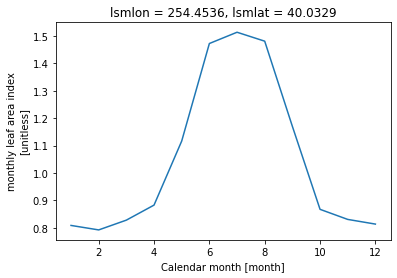

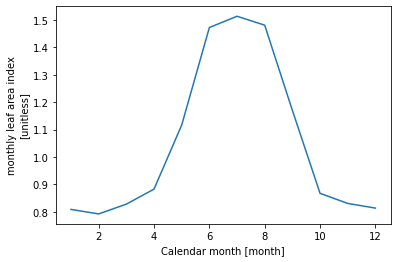

In [32]:
surDat = '/glade/p/cesmdata/inputdata/lnd/clm2/surfdata_map/release-clm5.0.18/surfdata_0.9x1.25_hist_16pfts_Irrig_CMIP6_simyr2000_c190214.nc'
surDat = xr.open_dataset(surDat)
surDat.MONTHLY_LAI.sel(lsmlon=204,lsmlat=138,lsmpft=1).plot();

In [33]:
surfdata_0.9x1.25_hist_16pfts_Irrig_CMIP6_simyr2000_US-NR1_c220922.nc surfdata_0.9x1.25_hist_16pfts_Irrig_CMIP6_simyr2000_US-NR1_LAIx2.66.nc

2.6666666666666665